In [1]:
import cv2
import numpy as np
import os
from random import shuffle
from tqdm import tqdm

In [23]:
train_dir = r'train'
test_dir = r'test'

In [24]:
img_size = 50
lr = 1e-3

model_name = 'dogsvscats-{}-{}.model'.format(lr, '6conv-basic')

In [25]:
def label_img(img):
    word_label = img.split('.')[-3]
    if word_label == 'cat': return [1,0]
    elif word_label == 'dog': return [0,1]

In [26]:
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(train_dir)):
        label = label_img(img)
        path = os.path.join(train_dir, img)
        img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE),(img_size, img_size))
        training_data.append([np.array(img), np.array(label)])
        
    shuffle(training_data)
    np.save('train_data.npy', training_data)
    return training_data

In [27]:
def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(test_dir)):
        path = os.path.join(test_dir, img)
        img_num = img.split('.')[0]
        img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (img_size, img_size))
        testing_data.append([np.array(img), img_num])
        
    np.save('test_data.npy', testing_data)
    return testing_data

In [28]:
train_data = create_train_data()

100%|████████████████████████████████████| 25000/25000 [00:49<00:00, 508.32it/s]
/Users/apple/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


In [29]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression
import tflearn.datasets.mnist as mnist

import tensorflow as tf

tf.compat.v1.reset_default_graph()


convnet = input_data(shape=[None, img_size, img_size, 1], name='input')

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=lr, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')

Instructions for updating:
non-resource variables are not supported in the long term
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


2022-10-28 21:46:55.753461: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [30]:
if os.path.exists('{}.meta'.format(model_name)):
    model.load(model_name)
    print('model loaded')

INFO:tensorflow:Restoring parameters from /Users/apple/Documents/Youtube_Training/Sentdex- ML-Python/dogsvscats-0.001-6conv-basic.model
model loaded


In [33]:
train = train_data[:-500]
test = train_data[-500:]

In [34]:
X = np.array([i[0] for i in train]).reshape(-1, img_size, img_size, 1)
Y = [i[1] for i in  train]

test_x = np.array([i[0] for i in test]).reshape(-1, img_size, img_size, 1)
test_y = [i[1] for i in test]

In [35]:
model.fit({'input': X}, {'targets': Y}, n_epoch=5, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id='mnist')

Training Step: 3829  | total loss: 0.38881 | time: 64.208s
| Adam | epoch: 005 | loss: 0.38881 - acc: 0.8254 -- iter: 24448/24500
Training Step: 3830  | total loss: 0.39617 | time: 65.351s
| Adam | epoch: 005 | loss: 0.39617 - acc: 0.8241 | val_loss: 0.48637 - val_acc: 0.7860 -- iter: 24500/24500
--


In [27]:
#tensorboard --logdir=foo:/log

In [28]:
model.save(model_name)

INFO:tensorflow:/Users/apple/Documents/Youtube_Training/Sentdex- ML-Python/dogsvscats-0.001-6conv-basic.model is not in all_model_checkpoint_paths. Manually adding it.


In [29]:
import matplotlib.pyplot as plt

# if you dont have this file yet
test_data = process_test_data()
# if you already have it
# test_data = mp.load('test_data.npy')

100%|████████████████████████████████████| 12500/12500 [00:21<00:00, 578.34it/s]
/Users/apple/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


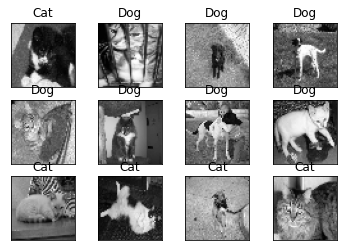

In [30]:
fig = plt.figure()

for num, data in enumerate(test_data[:12]):
    # cat: [1,0]
    # dog: [0,1]
    
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(3,4,num+1)
    orig = img_data
    data = img_data.reshape(img_size, img_size, 1)
    
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: str_label='Dog'
    else: str_label = 'Cat'
        
    y.imshow(orig, cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
    
plt.show()

In [38]:
with open('submission-file.csv','w') as f:
    f.write('id,label\n')

In [39]:
with open('submission-file.csv','a') as f:
    for data in tqdm(test_data):
        img_num = data[1]
        img_data = data[0]
        orig = img_data
        data = img_data.reshape(img_size, img_size,1)
        model_out = model.predict([data])[0]
        f.write('{},{}\n'.format(img_num, model_out[1]))

100%|████████████████████████████████████| 12500/12500 [00:17<00:00, 708.97it/s]
